# Grocery Store Sales - Time Series Forecasting(2)_Models

## 1.Introduction

Business problem: <br>
- Problem: As a large Ecuadorian-based grocery retailer, Corporación Favorita faces a significant challenge of accurately forecasting product demand to balance inventory levels. Overestimating leads to wastage of perishable goods, while underestimating results in stockouts and dissatisfied customers. Precise forecasting is crucial to optimize inventory, ensuring the availability of the right products at the right time and minimizing waste and revenue loss.
- Goal: To improve inventory management by accurately forecasting the unit sales for thousands of items sold at different Favorita stores, thus reducing food waste related to overstocking and enhancing customer satisfaction. 
- Challenge：Current subjective forecasting methods for retail have little data to back them up and are unlikely to be automated. The problem becomes even more complex as retailers <b>add new locations with unique needs, new products, ever-transitioning seasonal tastes, and unpredictable product marketing</b>.

Data Science problem (Define Project):
- Purpose of the project: To predict sales volumes ('sales') for each item from each product family ('family') at each store('store_nbr') in the period of 2017-08-16 to 2017-08-31 (the test dataset).<br> 
As the sales records in the test dataset are not known, we plan to split records as below:<br> 
*train *: 2013-01-01 to 2017-07-30 <br>
*validation *: 2017-07-31 to 2017-08-15<br>
*test *: 2017-08-16 to 2017-08-31
- Features: The training data includes dates, store('store_nbr') and product information('family'), whether that item was being promoted('onpromotion'), as well as the sales numbers('sales'). Additional files ('oil', 'transactions','holidays_events', 'stores' ) include supplementary information that may be useful in building your models.
- Time series : For the 54 stores and 33 families, there is a sale entry for each of their combination, totalling 1782 time series. Time series analysis will be performed on an average basis.
- Target: the sales volumne ('sales'). It can be viewed as a single series (single-output regression), or as 1782 time series (multi-output regression).
- Evaluation Metrics: Root Mean Squared Logarithmic Error (RMSLE).

## 2.Data preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import math
import datetime as datetime

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

from itertools import cycle
from scipy.signal import periodogram
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error

from warnings import simplefilter
simplefilter("ignore")

In [2]:
pd.reset_option('display.max_columns')

### load data
- *train.csv* The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- *store_nbr* identifies the store at which the products are sold.
- *family* identifies the type of product sold.
- *sales* gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips). 
- *onpromotion* gives the total number of items in a product family that were being promoted at a store at a given date.


- *test.csv*  The test data, having the same features as the training data. You will predict the target sales for the dates in this file. The dates in the test data are for the 15 days after the last date in the training data.

- *holidays_events.csv*  Holidays and Events, with metadata. NOTE: Pay special attention to the `transferred` column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

- *Additional Notes*  Wages in the public sector are paid `every two weeks` on the 15 th and on the last day of the month. Supermarket sales could be affected by this. A magnitude `7.8 earthquake` struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [3]:
os.listdir('data') #check all the data files in the project, there are 6

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
holidays_events = pd.read_csv('data/holidays_events.csv')
oil = pd.read_csv('data/oil.csv') # time range 2013-01-01 to 2017-08-31, daily crude oil West Texas Intermediate -Cushing, Oklahoma
transactions = pd.read_csv('data/transactions.csv') #time range 2013-01-01 to 2017-08-15
stores = pd.read_csv('data/stores.csv')

In [5]:
# Convert the 'date' column to datetime type
train.date = pd.to_datetime(train.date)
train['date'] = train.date.dt.to_period('D')   #have to do this, or dp.out_of_sample(steps=16) ->time_step
test.date = pd.to_datetime(test.date)
test['date'] = test.date.dt.to_period('D')
transactions.date = pd.to_datetime(transactions.date)
holidays_events.date = pd.to_datetime(holidays_events.date)

In [6]:
# clean up each file by assigning types and re-organizing indices, first train
# have to do this code, or cant't join test.id to y_summit successfully.
train = train.astype({'store_nbr': 'category',
                      'family': 'category',
                      'sales': 'float32',
                      'onpromotion': 'uint64'})
test = test.astype({'store_nbr': 'category',
                      'family': 'category',                      
                      'onpromotion': 'uint64'})

In [7]:
# Setting MultiIndex to make unique identifiers for each 'sales' item
train = train.set_index(['date', 'family', 'store_nbr']).sort_index()
test = test.set_index(['date', 'family', 'store_nbr']).sort_index()

In [8]:
holidays_events = (holidays_events.set_index('date')  #sets the 'date' column as the index
                   .to_period('D'))  #converts the index to a PeriodIndex with a daily frequency ('D')

In [ ]:
X_train = train.loc[:'2017-07-30']   # train: 2013-01-01 to 2017-07-30
y_train = (X_train
           .unstack(['family', 'store_nbr'])
           .loc[:,"sales"]
          )

X_val =train.loc['2017-07-31':]      # val: 2017-07-31 to 2017-08-15
y_val = (X_val
           .unstack(['family', 'store_nbr'])
           .loc[:,"sales"]
          )

X_test = test.copy()                # test: 2017-08-16 to 2017-08-31

# Simple index with dates
index_ = X_train.index.get_level_values('date').unique() 

### *A theoretical issue*: **MultiIndex**

In time series, we analyze temporal dependencies. We compare the state of the Target variable with itself at a different point in time. This implies a couple of things:

- Each unit of the target should be a time-indexed series containing a slice of information about the state of all objects at that moment. Thus, in each column, we will have a time-varying value of the same object. In other words, frozen pizza and bicycles will be in separate (independent) columns, and each of these columns will contain a time series of changes in the studied parameter (price, units sold, etc.).

- To ensure that pizza stays with pizza and bikes with bikes, the data needs to be grouped by all categorical features in the dataset and spread out into a 'wide' series. Then this series is taken at each new moment, and the DataFrame is configured line by line. This is our `y`

This is where a MultiIndex comes in handy.

1. You add all your categorical features to the index and make it a MultiIndex:  
`.set_index(['date', 'family', 'store_nbr']`. <br>
*Now, your index has 3 columns, and your TARGET is 1 value per row.*

2. You pivot all index levels but 'date' from columns (long format) to rows (wide format). Note that it's still the same MultiIndex!
`unstack(['family', 'store_nbr'])` <br>
*Now, your index has 1 column 'date' and 2 rows and your TARGET is **1782** values per row* 

Why is this helpful? Because now we have a standard **'dates'** column, just like any other time series. <br>
When you query `.loc['2017-01-01']`, you obtain an array of 1782 values, the result of 54 commodity families being sold in 33 stores, each uniquely indexed.

And what's in the columns? Precisely! Time-dependent changes for each of the 1782 values.<br> 
So, the Linear Regression model interprets 1782 separate vectors, which essentially means that we have 1782 different Linear Regression models in one.

In [ ]:
# # code Notes:
# X_train.index.get_level_values(0).min()
# X_train.index.get_level_values(0).max()

# # X_train with a MultiIndex consisting of 'date', 'family', and 'store_nbr'
# # Select before 2017-07-30
# X_train = train.loc[:'2017-07-30']
# # Select one specific family and store_nbr across all dates
# X_train.loc[(slice(None), 'selected_family', 'selected_store_nbr'), :]

# #After .unstack(['family', 'store_nbr']) columns from the MultiIndex.Here df has "date" index and one column with multiindex('family', 'store_nbr')
# #  -->e.g. y_train, y_train_pred.
# # Select one specific family and store_nbr across all dates
# y_train.loc[:, ('AUTOMOTIVE', slice(None))]
# # Get all unique values of the 'family' level
# y_train.columns.get_level_values('family').unique()

# #Self-study code notes: y_train has 'date' as index, has a column with multiindex of 'family' and 'store_nbr'
# #get mean across stores for each family
# y_train.groupby(level='family', axis=1).mean()
# # Select 'BOOKS' and get mean across stores for each date.
# y_train.loc[:, ('BOOKS', slice(None))].mean(axis=1)  #axis=1 : Calculate the mean for each row


### Visualization Settings

In [9]:
# matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="#556B2F",          
    style=".-",               
    markeredgecolor="#4169E1", 
    markerfacecolor="#8B0000", 
    legend=False              
)

%config InlineBackend.figure_format = 'retina'

## 3.Model Selection and Strategies for Forecasting

### Stretegies:
- 1) BASELINE MODEL: TREND (simple linear regression model
- 2) Capture seasonality

### 1)BASELINE MODEL: TREND (simple linear regression model)
- Public Score (RMSLE): **0.59435**

In [ ]:
#create trend features(Time-step feature) using DeterministicProcess. i.e. create a time dummy by counting out the length of the series(Time).
dp = DeterministicProcess(
    index = index_,     # dates from the training data        
    constant = True,    # dummy feature for the bias (y_intercept)
    order = 1,          # time-dummy (trend) #The order argument refers to polynomial order: 1(linear), 2(quadratic), 3(cubic), and so on.
    drop = True,        # drop terms if necessary to avoid collinearity          
)

X_time_train = dp.in_sample()  # `in_sample` creates features for the dates given in the `index` argument

# Create time-step features for validation set and test set
X_time = dp.out_of_sample(steps=32)   # 'out_of_sample (32)' means along the next 32 time-index labels ('days' in our case)
X_time.index.name = 'date'
X_time_val = X_time.loc[:'2017-08-15']
X_time_test = X_time.loc['2017-08-16':]
X_time_test

In [ ]:
"""
y_train has a 'wide' format and the model learns to predict not just 1 value, but 1782 at once(pre date).
"""
base_model = LinearRegression (fit_intercept = False).fit(X_time_train, y_train)

# # Save the baseline model to a file named 'baseline_model.pkl'
# joblib.dump(base_model, 'baseline_model.pkl')

In [13]:
# Load the saved model from the file
# base_model = joblib.load('./baseline_model.pkl')
y_train_pred = pd.DataFrame(base_model.predict(X_time_train),               
                        index = X_time_train.index,      
                        columns = y_train.columns
                        ).clip(0.0)
rmsle_train = mean_squared_log_error(y_train, y_train_pred) ** 0.5
print(f'Train RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Train RMSLE: 1.18483


In [15]:
y_val_pred = pd.DataFrame(base_model.predict(X_time_val),               
                        index = X_time_val.index,      
                        columns = y_train.columns
                        ).clip(0.0)   # Clip the predicted values to ensure they are non-negative, as Mean Squared Logarithmic Error cannot be used when targets contain negative values.
rmsle_train = mean_squared_log_error(y_val, y_val_pred) ** 0.5
print(f'Validation RMSLE: \033[1m{rmsle_train:.5f}\033[0m')

Validation RMSLE: 0.59508


In [ ]:
y_test_pred = pd.DataFrame(base_model.predict(X_time_test),               
                        index = X_time_test.index,      
                        columns = y_train.columns).clip(0.0)

In [20]:
# Compute Validation RMSLE for each family separately
rmsle_val_per_family = {}
## Get all unique values of the 'family' level. y_val has 'date' as index, has column of multiindex(family, store_nbr)
for f in list(y_val.columns.get_level_values('family').unique()):
    # select data for each family 
    y_val_family = y_val.loc[:, (f, slice(None))]
    y_val_pred_family = y_val_pred.loc[:, (f, slice(None))]
    rmsle_val_per_family[f] = np.sqrt(mean_squared_log_error(y_val_family, y_val_pred_family))

# Convert dictionary to DataFrame for easier analysis (optional)
rmsle_val_per_family_df = pd.DataFrame.from_dict(rmsle_val_per_family, orient='index', columns=['RMSLE'])
rmsle_val_per_family_df.sort_values(by=['RMSLE'])

,RMSLE
BOOKS,0.295948
GROCERY I,0.310406
BABY CARE,0.339336
DELI,0.341510
BREAD/BAKERY,0.346434
BEVERAGES,0.371703
DAIRY,0.373175
PERSONAL CARE,0.378673
CLEANING,0.390294
MEATS,0.397093


<Axes: xlabel='date'>

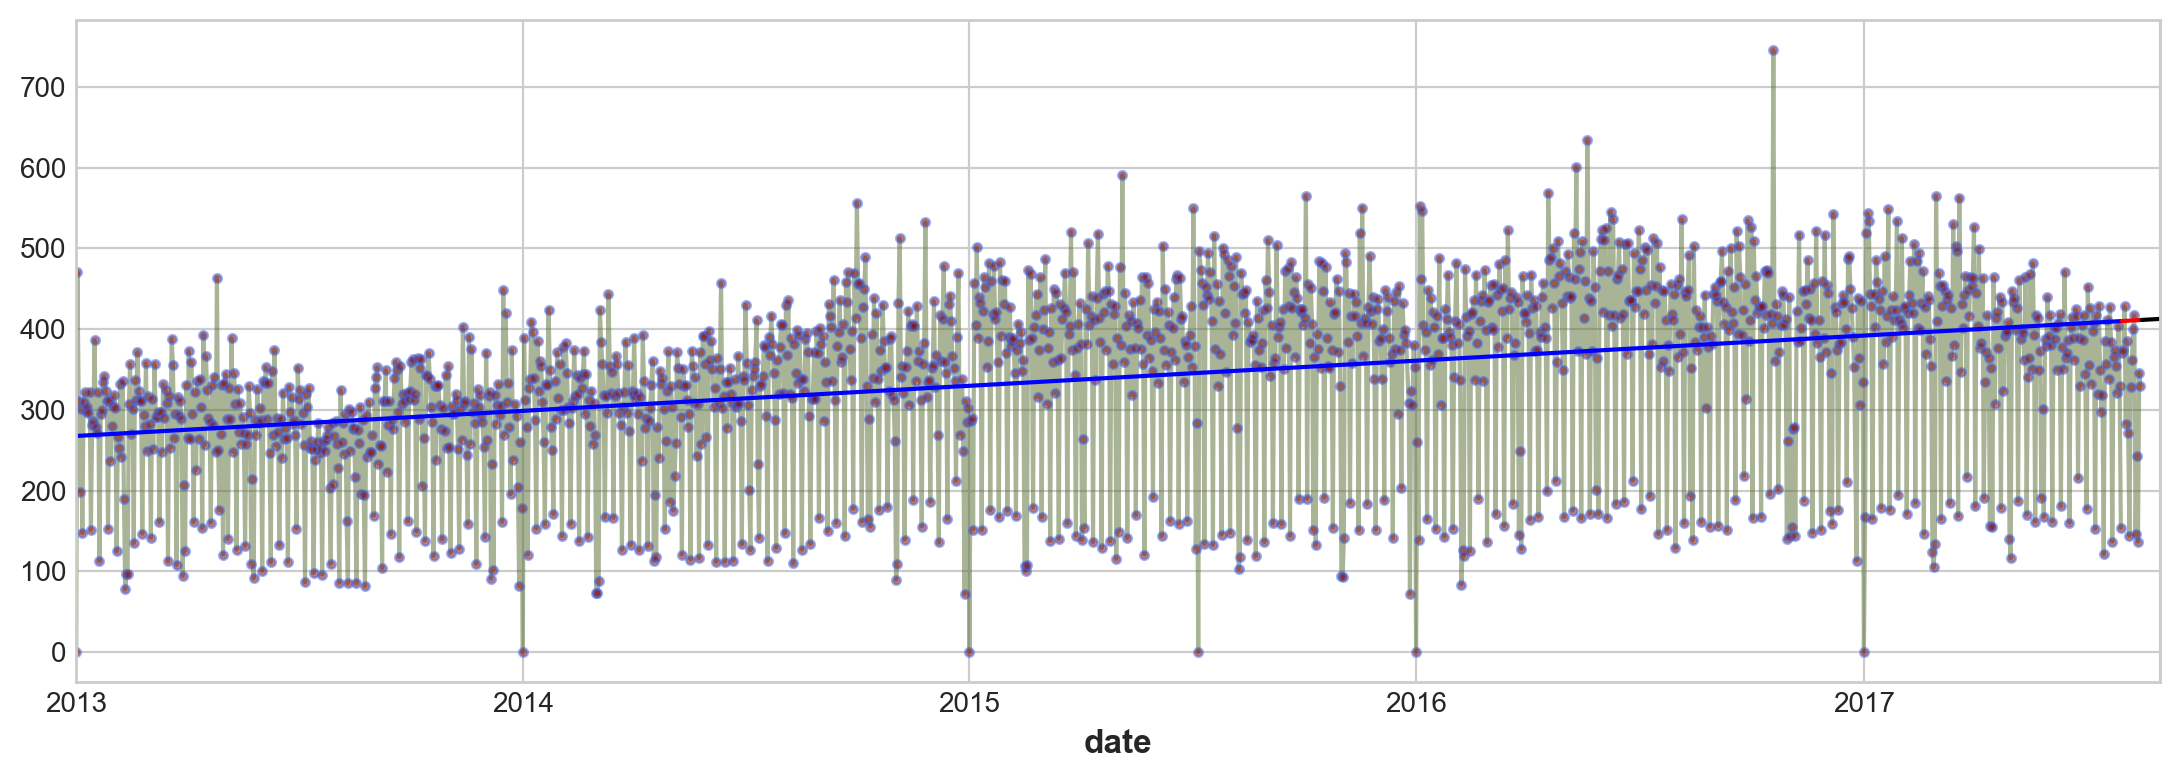

In [ ]:
"""
Visualizing fitted curves against average sales (rather than per-family AND per-store) 
in this section is mainly to save trouble replicating the time_dummy across the MultiIndex levels.
"""
# plot 'BREAD/BAKERY' as an example, as it has more frequent sales.
ax = y_train.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, alpha=0.5)
y_train_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="blue")
y_val.loc[:, ('BREAD/BAKERY', 1)].plot(**plot_params, ax=ax, alpha=0.5)
y_val_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="red")
y_test_pred.loc[:, ('BREAD/BAKERY', 1)].plot(ax=ax, color="black")
# if Prefix:
#     ax.set_title (f'{Prefix} for {FAMILY} at store {STORE} from {START} till {END}')
# else:
#     ax.set_title (f'Average sales of {FAMILY} from {START} till {END}')
# ax.legend()

In [63]:
# submission_0 = (y_test_pred
#             .stack(['family', 'store_nbr'])
#             .to_frame()
#             .join(test.id)   # Associate predictions with original IDs 
#             .rename(columns = {0:'sales'})
#             .reset_index(drop=True)
#             .reindex(columns = ['id','sales'])
#             )
# submission_0.to_csv('data/submission.csv', index=False)
# # # Notes: Retrieve the original IDs
# # original_ids = original_data.index
# # # Associate predictions with original IDs
# # predictions_with_ids = pd.DataFrame({'id': original_ids, 'y_pred': y_pred})

### 2).Strategy I: Seasons